In [89]:
import pandas as pd
from scipy.spatial import distance
from math import sin, cos, sqrt, atan2, radians
import time
import shapely
import fiona

from shapely.geometry import shape, Point
import shapely.wkt

from pyproj import Proj, transform

In [157]:
permits = pd.read_csv('data/nbrespermits.csv')
nypd2014_15 = pd.read_csv('../capstone_large_data_sets/nypd2014_15.csv')
nypd2015_16 = pd.read_csv('../capstone_large_data_sets/nypd2015_16.csv')
nypd2016_17 = pd.read_csv('../capstone_large_data_sets/nypd2016_17.csv')
nypd2017_18 = pd.read_csv('../capstone_large_data_sets/nypd2017_18.csv')
nypd2018_19 = pd.read_csv('../capstone_large_data_sets/nypd2018_19.csv')
nypd2019_20 = pd.read_csv('../capstone_large_data_sets/nypd2019_20.csv')

In [107]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721


In [158]:
nypd2014_15.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,604271687,2015-03-01,FELONY,BRONX,48.0,1011779.0,246746.0,40.843901,-73.900505


In [159]:
nypd2015_16.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,700078195,2016-06-10,FELONY,BRONX,45.0,1030139.0,244308.0,40.837133,-73.834164


In [160]:
nypd2016_17.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,216044876,2017-01-01,FELONY,QUEENS,109.0,1032198.0,217060.0,40.762334,-73.826917


In [161]:
nypd2017_18.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,954653095,2017-11-15,FELONY,QUEENS,107.0,1036790.0,205267.0,40.729939,-73.810433


In [162]:
nypd2018_19.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,750564667,2019-06-01,FELONY,BRONX,43.0,1020316.0,239179.0,40.823101,-73.86969


In [163]:
nypd2019_20.head(1)

,cmplnt_num,cmplnt_fr_dt,law_cat_cd,boro_nm,addr_pct_cd,x_coord_cd,y_coord_cd,latitude,longitude
0,394506329,2019-12-31,FELONY,MANHATTAN,32.0,999937.0,238365.0,40.820927,-73.943324


In [167]:
nypd2019_20['cmplnt_fr_dt'].value_counts()

2020-06-01    1911
2020-01-01    1810
2019-11-01    1538
2019-09-27    1507
2019-10-01    1480
              ... 
2020-03-22     745
2020-04-26     743
2020-04-04     728
2020-04-05     701
2020-03-29     633
Name: cmplnt_fr_dt, Length: 365, dtype: int64

## Breaking Data Up By Borough
Because the code to find the number of complaints within .1 miles takes a while to run, I broke the data up by borough. Ultimately, I broke Brooklyn's data up even further (see below).

In [111]:
permits_man = permits[permits['borough'] == 'MANHATTAN']
nypd2014_man = nypd2014_15[nypd2014_15['boro_nm'] == 'MANHATTAN']

permits_bx = permits[permits['borough'] == 'BRONX']
nypd2014_bx = nypd2014_15[nypd2014_15['boro_nm'] == 'BRONX']

permits_si = permits[permits['borough'] == 'STATEN ISLAND']
nypd2014_si = nypd2014_15[nypd2014_15['boro_nm'] == 'STATEN ISLAND']

permits_qn = permits[permits['borough'] == 'QUEENS']
nypd2014_qn = nypd2014_15[nypd2014_15['boro_nm'] == 'QUEENS']

permits_bk = permits[permits['borough'] == 'BROOKLYN']
nypd2014_bk = nypd2014_15[nypd2014_15['boro_nm'] == 'BROOKLYN']

In [214]:
# permits_man.drop(columns = 'complaints2014_15', inplace = True)

/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_43538/973930110.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits_man.drop(columns = 'complaints2014_15', inplace = True)


In [216]:
permits_man.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125
8,MANHATTAN,1806993,76,WEST 105TH STREET,121208380,10025,2022-05-12,PARTNERSHIP,N,40.798286,-73.962716
27,MANHATTAN,1024945,312,WEST 43RD STREET,121207309,10036,2022-05-24,CORPORATION,N,40.758182,-73.989973
35,MANHATTAN,1058625,217,WEST 123 STREET,123112648,10027,2022-06-06,PARTNERSHIP,N,40.808014,-73.950078


In [217]:
permits_man.to_csv('boro_data/permits_man.csv', index = False)
nypd2014_man.to_csv('../big_data/2014/nypd2014_man.csv', index = False)

permits_bx.to_csv('boro_data/permits_bx.csv', index = False)
nypd2014_bx.to_csv('../big_data/2014/nypd2014_bx.csv', index = False)

permits_si.to_csv('boro_data/permits_si.csv', index = False)
nypd2014_si.to_csv('../big_data/2014/nypd2014_si.csv', index = False)

permits_qn.to_csv('boro_data/permits_qn.csv', index = False)
nypd2014_qn.to_csv('../big_data/2014/nypd2014_qn.csv', index = False)

permits_bk.to_csv('boro_data/permits_bk.csv', index = False)
nypd2014_bk.to_csv('../big_data/2014/nypd2014_bk.csv', index = False)

In [169]:
nypd2015_man = nypd2015_16[nypd2015_16['boro_nm'] == 'MANHATTAN']
nypd2015_bx = nypd2015_16[nypd2015_16['boro_nm'] == 'BRONX']
nypd2015_si = nypd2015_16[nypd2015_16['boro_nm'] == 'STATEN ISLAND']
nypd2015_qn = nypd2015_16[nypd2015_16['boro_nm'] == 'QUEENS']
nypd2015_bk = nypd2015_16[nypd2015_16['boro_nm'] == 'BROOKLYN']

nypd2015_man.to_csv('../big_data/2015/nypd2015_man.csv', index = False)
nypd2015_bx.to_csv('../big_data/2015/nypd2015_bx.csv', index = False)
nypd2015_si.to_csv('../big_data/2015/nypd2015_si.csv', index = False)
nypd2015_qn.to_csv('../big_data/2015/nypd2015_qn.csv', index = False)
nypd2015_bk.to_csv('../big_data/2015/nypd2015_bk.csv', index = False)

In [172]:
nypd2016_man = nypd2016_17[nypd2016_17['boro_nm'] == 'MANHATTAN']
nypd2016_bx = nypd2016_17[nypd2016_17['boro_nm'] == 'BRONX']
nypd2016_si = nypd2016_17[nypd2016_17['boro_nm'] == 'STATEN ISLAND']
nypd2016_qn = nypd2016_17[nypd2016_17['boro_nm'] == 'QUEENS']
nypd2016_bk = nypd2016_17[nypd2016_17['boro_nm'] == 'BROOKLYN']

nypd2016_man.to_csv('../big_data/2016/nypd2016_man.csv', index = False)
nypd2016_bx.to_csv('../big_data/2016/nypd2016_bx.csv', index = False)
nypd2016_si.to_csv('../big_data/2016/nypd2016_si.csv', index = False)
nypd2016_qn.to_csv('../big_data/2016/nypd2016_qn.csv', index = False)
nypd2016_bk.to_csv('../big_data/2016/nypd2016_bk.csv', index = False)

In [173]:
nypd2017_man = nypd2017_18[nypd2017_18['boro_nm'] == 'MANHATTAN']
nypd2017_bx = nypd2017_18[nypd2017_18['boro_nm'] == 'BRONX']
nypd2017_si = nypd2017_18[nypd2017_18['boro_nm'] == 'STATEN ISLAND']
nypd2017_qn = nypd2017_18[nypd2017_18['boro_nm'] == 'QUEENS']
nypd2017_bk = nypd2017_18[nypd2017_18['boro_nm'] == 'BROOKLYN']

nypd2017_man.to_csv('../big_data/2017/nypd2017_man.csv', index = False)
nypd2017_bx.to_csv('../big_data/2017/nypd2017_bx.csv', index = False)
nypd2017_si.to_csv('../big_data/2017/nypd2017_si.csv', index = False)
nypd2017_qn.to_csv('../big_data/2017/nypd2017_qn.csv', index = False)
nypd2017_bk.to_csv('../big_data/2017/nypd2017_bk.csv', index = False)

In [174]:
nypd2018_man = nypd2018_19[nypd2018_19['boro_nm'] == 'MANHATTAN']
nypd2018_bx = nypd2018_19[nypd2018_19['boro_nm'] == 'BRONX']
nypd2018_si = nypd2018_19[nypd2018_19['boro_nm'] == 'STATEN ISLAND']
nypd2018_qn = nypd2018_19[nypd2018_19['boro_nm'] == 'QUEENS']
nypd2018_bk = nypd2018_19[nypd2018_19['boro_nm'] == 'BROOKLYN']

nypd2018_man.to_csv('../big_data/2018/nypd2018_man.csv', index = False)
nypd2018_bx.to_csv('../big_data/2018/nypd2018_bx.csv', index = False)
nypd2018_si.to_csv('../big_data/2018/nypd2018_si.csv', index = False)
nypd2018_qn.to_csv('../big_data/2018/nypd2018_qn.csv', index = False)
nypd2018_bk.to_csv('../big_data/2018/nypd2018_bk.csv', index = False)

In [117]:
nypd2019_man = nypd2019_20[nypd2019_20['boro_nm'] == 'MANHATTAN']
nypd2019_bx = nypd2019_20[nypd2019_20['boro_nm'] == 'BRONX']
nypd2019_si = nypd2019_20[nypd2019_20['boro_nm'] == 'STATEN ISLAND']
nypd2019_qn = nypd2019_20[nypd2019_20['boro_nm'] == 'QUEENS']
nypd2019_bk = nypd2019_20[nypd2019_20['boro_nm'] == 'BROOKLYN']

nypd2019_man.to_csv('../big_data/2019/nypd2019_man.csv', index = False)
nypd2019_bx.to_csv('../big_data/2019/nypd2019_bx.csv', index = False)
nypd2019_si.to_csv('../big_data/2019/nypd2019_si.csv', index = False)
nypd2019_qn.to_csv('../big_data/2019/nypd2019_qn.csv', index = False)
nypd2019_bk.to_csv('../big_data/2019/nypd2019_bk.csv', index = False)

In [212]:
permits_man.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2014_15
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,346.0
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,NaN
8,MANHATTAN,1806993,76,WEST 105TH STREET,121208380,10025,2022-05-12,PARTNERSHIP,N,40.798286,-73.962716,NaN
27,MANHATTAN,1024945,312,WEST 43RD STREET,121207309,10036,2022-05-24,CORPORATION,N,40.758182,-73.989973,NaN
35,MANHATTAN,1058625,217,WEST 123 STREET,123112648,10027,2022-06-06,PARTNERSHIP,N,40.808014,-73.950078,NaN


In [213]:
permits_si.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude
7,STATEN ISLAND,5174981,52,BURKE AVENUE,540195386,10314,2022-05-12,PARTNERSHIP,N,40.593267,-74.188737
19,STATEN ISLAND,5174979,48,BURKE AVENUE,540195368,10314,2022-05-20,PARTNERSHIP,N,40.593289,-74.188777
20,STATEN ISLAND,5174980,50,BURKE AVENUE,540195377,10314,2022-05-20,PARTNERSHIP,N,40.593278,-74.188759
67,STATEN ISLAND,5013482,84,PROSPECT STREET,520223641,10304,2022-06-01,CORPORATION,N,40.628541,-74.077081
130,STATEN ISLAND,5171608,109,YETMAN AVE,510113333,10307,2022-06-23,INDIVIDUAL,N,40.513346,-74.246802


### Splitting Brooklyn Up
I found I needed to split Brooklyn up to get a result. AWS kept breaking off what was running in my instance before the Brooklyn dataset could finish running.

In [114]:
permits_bk.shape

(2193, 11)

In [118]:
permits_bk1 = permits_bk[:731]
permits_bk2 = permits_bk[731:1462]
permits_bk3 = permits_bk[1462:]

In [119]:
print(permits_bk1.shape)
print(permits_bk2.shape)
print(permits_bk3.shape)

(731, 11)
(731, 11)
(731, 11)


In [120]:
permits_bk1.to_csv('boro_data/permits_bk1.csv', index = False)
permits_bk2.to_csv('boro_data/permits_bk2.csv', index = False)
permits_bk3.to_csv('boro_data/permits_bk3.csv', index = False)

In [153]:
permits_bk2['longitude'].describe()

count    731.000000
mean     -73.947761
std        0.034179
min      -74.038867
25%      -73.969527
50%      -73.949353
75%      -73.926199
max      -73.858687
Name: longitude, dtype: float64

In [156]:
nypd2014_bk.shape[0]/nypd2014_15.shape[0]

0.301458453754199

# The Code for Complaints
I tried many iterations to speed it up and ultimately landed on this. This version of it is set up for a test on the first row of data.

I ultimately realized that seting a value for max_delt_lat and max_delt_long instead of using a variable, while making it harder to change that value quickly, would likely make the code a little faster.

[This stackoverflow](https://stackoverflow.com/questions/66470898/finding-pairs-of-latitude-and-longitude-within-a-certain-radius-in-python) was the first source I found for code on calculating distance between two points. It was largely sourced from this
[the stackoverflow](https://stackoverflow.com/questions/57294120/calculating-distance-between-latitude-and-longitude-in-python), which the first author cites. This second answer (combined with [this Earth fact sheet from Nasa](https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html)) clarifies that R is the volumetric mean radius, or 6371 in km. This translates to 4182 miles.

I used 69 miles to the degree latitude, though it varies some.

At 48 degrees latitude, 1 degree longitude is about 40 miles. I used [this calculator](https://www.nhc.noaa.gov/gccalc.shtml) to find that.

In [124]:
def get_distance(point1, point2):
    R = 4182 #miles
    lat1 = radians(point1[0])  #insert value
    lon1 = radians(point1[1])
    lat2 = radians(point2[0])
    lon2 = radians(point2[1])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))
    distance = R * c
    return distance


# note: the latitude and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree late = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690
max_delt_long = 1/400


t0 = time.time()
for i in [0]: #<----THIS IS SET UP FOR A TEST
    lat = permits_man.loc[i, 'latitude']
    long = permits_man.loc[i, 'longitude']
    point1 = [lat, long]
    complaint_count = 0
    for n in nypd2014_man.index:
        n_lat = nypd2014_man.loc[n, 'latitude']
        n_long = nypd2014_man.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .1:
                complaint_count += 1
    permits_man.loc[i, 'complaints2014_15'] = complaint_count

print('')
print("Time to run", time.time()-t0)


Time to run 1.582650899887085


/var/folders/5_/498w081d1837cc82dmb4hwmc0000gn/T/ipykernel_43538/82551024.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  permits_man.loc[i, 'complaints2014_15'] = complaint_count


### Separate `.py` Files For the Cloud
I took the above code and put it into `.py` files to run in AWS. I wound up needing more than one because AWS interrupted the file before it had finished producing all its outputs.

#### Some Notes on AWS
240 Manhattan entries took 871.3408896923065 seconds in the cloud.

I used Ubuntu and c3.8xlarge

This looks like it might be faster c5a.8xlarge

# Combining the Resulting Data Frames for Complaints
First by year, then all together.

## 2014

In [218]:
complaints2014_bk1 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk1.csv')
complaints2014_bk2 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk2.csv')
complaints2014_bk3 = pd.read_csv('../perms_with_nypd/permits_complaints2014_bk3.csv')

complaints2014_bx = pd.read_csv('../perms_with_nypd/permits_complaints2014_bx.csv')
complaints2014_man = pd.read_csv('../perms_with_nypd/permits_complaints2014_man.csv')
complaints2014_qn = pd.read_csv('../perms_with_nypd/permits_complaints2014_qn.csv')
complaints2014_si = pd.read_csv('../perms_with_nypd/permits_complaints2014_si.csv')

In [222]:
complaints2014_bk1.drop(columns = ['Unnamed: 0'], inplace = True)

complaints2014_bk2.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_bk3.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2014_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [228]:
complaints2014_si.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2014_15
0,STATEN ISLAND,5174981,52,BURKE AVENUE,540195386,10314,2022-05-12,PARTNERSHIP,N,40.593267,-74.188737,8.0
1,STATEN ISLAND,5174979,48,BURKE AVENUE,540195368,10314,2022-05-20,PARTNERSHIP,N,40.593289,-74.188777,8.0
2,STATEN ISLAND,5174980,50,BURKE AVENUE,540195377,10314,2022-05-20,PARTNERSHIP,N,40.593278,-74.188759,8.0
3,STATEN ISLAND,5013482,84,PROSPECT STREET,520223641,10304,2022-06-01,CORPORATION,N,40.628541,-74.077081,72.0
4,STATEN ISLAND,5171608,109,YETMAN AVE,510113333,10307,2022-06-23,INDIVIDUAL,N,40.513346,-74.246802,9.0


In [229]:
print(f'Len bk1: {len(complaints2014_bk1)}')
print(f'Len bk2: {len(complaints2014_bk2)}')
print(f'Len bk3: {len(complaints2014_bk3)}')
print(f'Len bx: {len(complaints2014_bx)}')
print(f'Len man: {len(complaints2014_man)}')
print(f'Len qn: {len(complaints2014_qn)}')
print(f'Len si: {len(complaints2014_si)}')

Len bk1: 731
Len bk2: 731
Len bk3: 731
Len bx: 729
Len man: 280
Len qn: 2078
Len si: 1896


In [230]:
len(complaints2014_bk1)+len(complaints2014_bk2)+len(complaints2014_bk3)+len(complaints2014_bx)+len(complaints2014_man)+len(complaints2014_qn)+ len(complaints2014_si)


7176

In [231]:
complaints2014 = pd.concat([complaints2014_bk1, complaints2014_bk2, complaints2014_bk3, complaints2014_bx, complaints2014_man, complaints2014_qn, complaints2014_si])


In [234]:
len(complaints2014)

7176

## 2015

In [238]:
complaints2015_bk = pd.read_csv('../perms_with_nypd/permits_complaints2015_bk.csv')
complaints2015_bx = pd.read_csv('../perms_with_nypd/permits_complaints2015_bx.csv')
complaints2015_man = pd.read_csv('../perms_with_nypd/permits_complaints2015_man.csv')
complaints2015_qn = pd.read_csv('../perms_with_nypd/permits_complaints2015_qn.csv')
complaints2015_si = pd.read_csv('../perms_with_nypd/permits_complaints2015_si.csv')

In [239]:
complaints2015_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2015_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [240]:
len(complaints2015_bk)+len(complaints2015_bx)+len(complaints2015_man)+len(complaints2015_qn)+ len(complaints2015_si)


7176

In [241]:
complaints2015 = pd.concat([complaints2015_bk, complaints2015_bx, complaints2015_man, complaints2015_qn, complaints2015_si])


In [244]:
len(complaints2015)

7176

In [243]:
complaints2015.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,complaints2015_16,complaints2014_15
0,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,50.0,NaN
1,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,117.0,NaN
2,BROOKLYN,3122029,150,TERRACE PLACE,340796151,11218,2022-05-16,INDIVIDUAL,N,40.655274,-73.976642,17.0,NaN
3,BROOKLYN,3815647,2922,FULTON ST,322039888,11207,2022-05-12,CORPORATION,N,40.679221,-73.886894,154.0,NaN
4,BROOKLYN,3256553,842,LIBERTY AVE,321327863,11208,2022-06-03,INDIVIDUAL,N,40.677058,-73.878443,47.0,NaN


# 2016

In [245]:
complaints2016_bk = pd.read_csv('../perms_with_nypd/permits_complaints2016_bk.csv')
complaints2016_bx = pd.read_csv('../perms_with_nypd/permits_complaints2016_bx.csv')
complaints2016_man = pd.read_csv('../perms_with_nypd/permits_complaints2016_man.csv')
complaints2016_qn = pd.read_csv('../perms_with_nypd/permits_complaints2016_qn.csv')
complaints2016_si = pd.read_csv('../perms_with_nypd/permits_complaints2016_si.csv')

In [246]:
complaints2016_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2016_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [247]:
len(complaints2016_bk)+len(complaints2016_bx)+len(complaints2016_man)+len(complaints2016_qn)+ len(complaints2016_si)


7176

In [248]:
complaints2016 = pd.concat([complaints2016_bk, complaints2016_bx, complaints2016_man, complaints2016_qn, complaints2016_si])


In [249]:
len(complaints2016)

7176

# 2017

In [250]:
complaints2017_bk = pd.read_csv('../perms_with_nypd/permits_complaints2017_bk.csv')
complaints2017_bx = pd.read_csv('../perms_with_nypd/permits_complaints2017_bx.csv')
complaints2017_man = pd.read_csv('../perms_with_nypd/permits_complaints2017_man.csv')
complaints2017_qn = pd.read_csv('../perms_with_nypd/permits_complaints2017_qn.csv')
complaints2017_si = pd.read_csv('../perms_with_nypd/permits_complaints2017_si.csv')

In [251]:
complaints2017_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2017_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [252]:
len(complaints2017_bk)+len(complaints2017_bx)+len(complaints2017_man)+len(complaints2017_qn)+ len(complaints2017_si)


7176

In [253]:
complaints2017 = pd.concat([complaints2017_bk, complaints2017_bx, complaints2017_man, complaints2017_qn, complaints2017_si])


In [254]:
len(complaints2017)

7176

# 2018

In [255]:
complaints2018_bk = pd.read_csv('../perms_with_nypd/permits_complaints2018_bk.csv')
complaints2018_bx = pd.read_csv('../perms_with_nypd/permits_complaints2018_bx.csv')
complaints2018_man = pd.read_csv('../perms_with_nypd/permits_complaints2018_man.csv')
complaints2018_qn = pd.read_csv('../perms_with_nypd/permits_complaints2018_qn.csv')
complaints2018_si = pd.read_csv('../perms_with_nypd/permits_complaints2018_si.csv')

In [256]:
complaints2018_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2018_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [257]:
len(complaints2018_bk)+len(complaints2018_bx)+len(complaints2018_man)+len(complaints2018_qn)+ len(complaints2018_si)


7176

In [258]:
complaints2018 = pd.concat([complaints2018_bk, complaints2018_bx, complaints2018_man, complaints2018_qn, complaints2018_si])


In [259]:
len(complaints2018)

7176

# 2019

In [260]:
complaints2019_bk = pd.read_csv('../perms_with_nypd/permits_complaints2019_bk.csv')
complaints2019_bx = pd.read_csv('../perms_with_nypd/permits_complaints2019_bx.csv')
complaints2019_man = pd.read_csv('../perms_with_nypd/permits_complaints2019_man.csv')
complaints2019_qn = pd.read_csv('../perms_with_nypd/permits_complaints2019_qn.csv')
complaints2019_si = pd.read_csv('../perms_with_nypd/permits_complaints2019_si.csv')

In [261]:
complaints2019_bk.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_bx.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_man.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_qn.drop(columns = ['Unnamed: 0'], inplace = True)
complaints2019_si.drop(columns = ['Unnamed: 0'], inplace = True)

In [262]:
len(complaints2019_bk)+len(complaints2019_bx)+len(complaints2019_man)+len(complaints2019_qn)+ len(complaints2019_si)


7176

In [263]:
complaints2019 = pd.concat([complaints2019_bk, complaints2019_bx, complaints2019_man, complaints2019_qn, complaints2019_si])


In [264]:
len(complaints2019)

7176

# All Complaints

In [267]:
complaints_all = complaints2014[['job_no','complaints2014_15']]

In [268]:
complaints_all.head()

,job_no,complaints2014_15
0,321588215,66.0
1,321827163,126.0
2,340796151,16.0
3,322039888,125.0
4,321327863,58.0


In [272]:
complaints_all = complaints_all.merge(complaints2015[['job_no','complaints2015_16']], on = 'job_no')

In [274]:
complaints_all = complaints_all.merge(complaints2016[['job_no','complaints2016_17']], on = 'job_no')

In [276]:
complaints_all = complaints_all.merge(complaints2017[['job_no','complaints2017_18']], on = 'job_no')

In [278]:
complaints_all = complaints_all.merge(complaints2018[['job_no','complaints2018_19']], on = 'job_no')

In [280]:
complaints_all = complaints_all.merge(complaints2019[['job_no','complaints2019_20']], on = 'job_no')

In [281]:
complaints_all

,job_no,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20
0,321588215,66.0,50.0,44.0,45.0,56.0,32.0
1,321827163,126.0,117.0,103.0,107.0,100.0,89.0
2,340796151,16.0,17.0,15.0,25.0,19.0,20.0
3,322039888,125.0,154.0,127.0,125.0,84.0,99.0
4,321327863,58.0,47.0,68.0,72.0,54.0,61.0
...,...,...,...,...,...,...,...
7171,520318932,4.0,7.0,5.0,6.0,8.0,4.0
7172,520325595,50.0,56.0,40.0,44.0,28.0,61.0
7173,520385896,25.0,36.0,44.0,33.0,25.0,25.0
7174,520386109,5.0,5.0,8.0,4.0,3.0,7.0


In [283]:
complaints_all.to_csv('../backup_data/allcomplaints.csv', index = False)

In [285]:
permits = permits.merge(complaints_all, on= 'job_no')

In [286]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,...,in_hist_dist,point,closest_park,name_closest_park,complaints2014_15,complaints2015_16,complaints2016_17,complaints2017_18,complaints2018_19,complaints2019_20
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,...,0.0,POINT (-73.96874 40.798817),0.000000,Broadway Malls,346.0,392.0,358.0,428.0,365.0,366.0
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,...,0.0,POINT (-73.926125 40.860296),0.049425,Highbridge Park,145.0,140.0,116.0,115.0,94.0,91.0
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,...,0.0,POINT (-73.918118 40.818565),0.086285,Melrose Playground,291.0,327.0,254.0,240.0,243.0,223.0
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,...,0.0,POINT (-73.943944 40.636513),0.141644,Nostrand Playground,66.0,50.0,44.0,45.0,56.0,32.0
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,...,0.0,POINT (-73.949721 40.634773),0.199042,Nostrand Playground,126.0,117.0,103.0,107.0,100.0,89.0


# Subway Entrances
I decided to look at numbers of entrances within tenth, half, one, and 2.5 mile radii of the permit. I wanted to find the closest entrance, along with half mile, but that would be very calculation intensive and take too long to run.

In [125]:
subways = pd.read_csv('data/subway_cleaned.csv')

In [126]:
subways.head()

,objectid,name,line,latitude,longitude
0,1734,Birchall Ave & Sagamore St at NW corner,2-5,40.849169,-73.868356
1,1735,Birchall Ave & Sagamore St at NE corner,2-5,40.849128,-73.868213
2,1736,Morris Park Ave & 180th St at NW corner,2-5,40.841223,-73.873499
3,1737,Morris Park Ave & 180th St at NW corner,2-5,40.841453,-73.872892
4,1738,Boston Rd & 178th St at SW corner,2-5,40.840815,-73.879623


In [130]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,5.0,15.0,42.0,195.0
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,2.0,15.0,34.0,153.0
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,0.0,9.0,60.0,215.0
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,0.0,11.0,13.0,95.0
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,0.0,11.0,20.0,87.0


In [133]:
# note: the lati../backup_data/and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree late = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690 #CHANGE HERE
max_delt_long = 1/400 #CHANGE HERE

t0 = time.time()
print("Tenth mile started ", t0)
permits.loc[i, 'subway_count_tenth_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .1: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_tenth_mi'] = entrance_count #CHANGE HERE

print("Time to run tenth mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 5/690 #CHANGE HERE
max_delt_long = 5/400 #CHANGE HERE

t0 = time.time()
print("Half mile started ", t0)
permits.loc[i, 'subway_count_half_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= .5: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_half_mi'] = entrance_count #CHANGE HERE


print("Time to run half mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 10/690 #CHANGE HERE
max_delt_long = 10/400 #CHANGE HERE

t0 = time.time()
print("Mile started ", t0)
permits.loc[i, 'subway_count_one_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= 1: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_one_mi'] = entrance_count #CHANGE HERE

print("Time to run one mile:", time.time()-t0) #CHANGE HERE
print('')

max_delt_lat = 25/690 #CHANGE HERE
max_delt_long = 25/400 #CHANGE HERE

t0 = time.time()
print("2.5 mile started ", t0)
permits.loc[i, 'subway_count_two_five_mi'] = 0 #CHANGE HERE
for i in permits.index:
    lat = permits.loc[i, 'latitude']
    long = permits.loc[i, 'longitude']
    point1 = [lat, long]
    entrance_count = 0
    for n in subways.index:
        n_lat = subways.loc[n, 'latitude']
        n_long = subways.loc[n, 'longitude']
        if (abs(lat - n_lat)<= max_delt_lat) or (abs(lat - n_long)<= max_delt_long):
            point2 = [n_lat, n_long]
            distance = get_distance(point1, point2)
            if distance <= 2.5: #CHANGE HERE
                entrance_count += 1
    permits.loc[i, 'subway_count_two_five_mi'] = entrance_count #CHANGE HERE

print("Time to run 2.5 mile:", time.time()-t0) #CHANGE HERE
print('')

Tenth mile started  1660092238.8299189
Time to run tenth mile: 151.76178216934204

Half mile started  1660092390.592167
Time to run half mile: 151.12384724617004

Mile started  1660092541.716223
Time to run one mile: 155.0053629875183

2.5 mile started  1660092696.721838
Time to run 2.5 mile: 156.59649896621704



In [134]:
permits['subway_count_tenth_mi'].value_counts()

0.0     6568
2.0      219
1.0      163
4.0       97
3.0       77
8.0       15
6.0       14
5.0       13
7.0        3
9.0        1
16.0       1
14.0       1
11.0       1
15.0       1
10.0       1
12.0       1
Name: subway_count_tenth_mi, dtype: int64

In [135]:
permits['subway_count_half_mi'].value_counts()

0.0     3150
2.0      407
4.0      394
8.0      306
6.0      306
        ... 
69.0       1
88.0       1
92.0       1
41.0       1
70.0       1
Name: subway_count_half_mi, Length: 70, dtype: int64

In [136]:
permits['subway_count_one_mi'].value_counts()

0.0      1862
3.0       291
5.0       251
4.0       210
8.0       205
         ... 
137.0       1
83.0        1
145.0       1
202.0       1
151.0       1
Name: subway_count_one_mi, Length: 161, dtype: int64

In [137]:
permits['subway_count_two_five_mi'].value_counts()

0.0      730
16.0     355
17.0     296
14.0     232
12.0     222
        ... 
372.0      1
398.0      1
481.0      1
525.0      1
246.0      1
Name: subway_count_two_five_mi, Length: 458, dtype: int64

In [138]:
permits.to_csv('../backup_data/permits_subway_backup.csv', index = False)

In [6]:
# permits = pd.read_csv('../backup_data/permits_subway_backup.csv')

# Historic Districts
Determing if a permit is located in a historic district.

In [139]:
permits.loc[0, 'point'] = 0

In [140]:
for i in permits.index:
    permits.loc[i, 'point'] = shapely.geometry.Point(permits.loc[i, 'longitude'], permits.loc[i, 'latitude'])

/Users/lorendunn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/blocks.py:930: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return self.coerce_to_target_dtype(value).setitem(indexer, value)
/Users/lorendunn/opt/anaconda3/lib/python3.9/site-packages/pandas/core/internals/managers.py:304: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  applied = getattr(b, f)(**kwargs)


In [141]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,point
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,5.0,15.0,42.0,195.0,none,0.0,POINT (-73.96874 40.798817)
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,2.0,15.0,34.0,153.0,none,0.0,POINT (-73.926125 40.860296)
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,0.0,9.0,60.0,215.0,none,0.0,POINT (-73.918118 40.818565)
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,0.0,11.0,13.0,95.0,none,0.0,POINT (-73.943944 40.636513)
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,0.0,11.0,20.0,87.0,none,0.0,POINT (-73.949721 40.634773)


In [142]:
for i in permits.index:
    permits.loc[i, 'hist_dist_name'] = 'none'

for i in permits.index:
    permits.loc[i, 'in_hist_dist'] = 0

## Used CSV With Latitude and Longitude Data for Historic Districts
I opted to use this instead of a shapefile because of the difficulty of converting latitude and longitude (WGS84) to NAD83. I wanted to be certain the geographic coordinates were all on the same scale.

This [stackoverflow answer](https://stackoverflow.com/a/18749373/5394724) showed me the basic approach to checking if a point is within a given area using shapely. I modified this because that answer was for one element and I have 154 historic districts, and because I used latitude and longitude from a .csv and this author used a shapefile. 

[This stackoverflow answer](https://stackoverflow.com/a/51892594/5394724) showed me how to make the shape using the long and latitude from the csv.

In [143]:
historic_dists = pd.read_csv('../historic_districts/LPC_HD_OpenData_2015Nov.csv')

In [144]:
historic_dists.columns

Index(['the_geom', 'BOROUGH', 'LP_NUMBER', 'CURRENT_', 'AREA_NAME',
       'EXTENSION', 'STATUS_OF_', 'LAST_ACTIO', 'BOUNDARY_N', 'PUBLIC_HEA',
       'OTHER_HEAR', 'DESDATE', 'CALDATE', 'Shape_Leng', 'Shape_Area'],
      dtype='object')

In [145]:
historic_dists.columns = historic_dists.columns.str.lower()

In [146]:
historic_dists.head()

,the_geom,borough,lp_number,current_,area_name,extension,status_of_,last_actio,boundary_n,public_hea,other_hear,desdate,caldate,shape_leng,shape_area
0,MULTIPOLYGON (((-73.78070476564865 40.79368791...,QN,LP-02040,Yes,Fort Totten Historic District,No,DESIGNATED,DESIGNATED,NaN,5/4/1999,NaN,6/29/1999,4/13/1999,11203.199722,4.067523e+06
1,MULTIPOLYGON (((-73.9545180987722 40.781621828...,MN,LP-01985,Yes,Hardenbergh/Rhinelander Historic District,No,DESIGNATED,DESIGNATED,NaN,3/10/1998,NaN,5/5/1998,NaN,410.860307,1.065242e+04
2,MULTIPOLYGON (((-74.00855983447059 40.71123470...,MN,LP-01901,Yes,African Burial Ground & The Commons Historic D...,No,DESIGNATED,DESIGNATED,NaN,9/1/1992,NaN,2/25/1993,NaN,4995.471462,1.069203e+06
3,MULTIPOLYGON (((-73.9595480661095 40.648261608...,BK,LP-00989,Yes,Albemarle-Kenmore Terraces Historic District,No,DESIGNATED,DESIGNATED,NaN,1/10/1978,NaN,7/11/1978,NaN,1240.770438,7.854686e+04
4,MULTIPOLYGON (((-73.96103396183 40.65868182663...,BK,LP-02567,Yes,Chester Court Historic District,No,DESIGNATED,DESIGNATED,AS IDENTIFIED BY RESEARCH DEPARTMENT (AND DETE...,11/25/2014,NaN,12/16/2014,10/28/2014,803.900855,3.840307e+04


In [147]:
t0 = time.time()

for i in range(len(historic_dists)):
    print(i)
    t1 = time.time()
    shape = shapely.wkt.loads(historic_dists['the_geom'][i])
    minx, miny, maxx, maxy = shape.bounds
    bounding_box = shapely.geometry.box(minx, miny, maxx, maxy)
    for n in permits.index:
        if permits.loc[n, 'in_hist_dist'] != 1:
            point = permits.loc[n, 'point']
            if bounding_box.contains(point):
                if shape.contains(point):
                    permits.loc[n, 'in_hist_dist'] = 1
                    permits.loc[n, 'hist_dist_name'] = historic_dists.loc[i, 'area_name']
    print(f"Time from start to end of {i} loop: {time.time()-t0}")
    print(f"Time to run the {i} loop: {time.time()-t1}")
    print('')
print(f"Total time: {time.time()-t0}")

0
Time from start to end of 0 loop: 0.13018512725830078
Time to run the 0 loop: 0.12942099571228027

1
Time from start to end of 1 loop: 0.22683405876159668
Time to run the 1 loop: 0.09664106369018555

2
Time from start to end of 2 loop: 0.3256711959838867
Time to run the 2 loop: 0.09876203536987305

3
Time from start to end of 3 loop: 0.42232489585876465
Time to run the 3 loop: 0.09660696983337402

4
Time from start to end of 4 loop: 0.5207579135894775
Time to run the 4 loop: 0.09842300415039062

5
Time from start to end of 5 loop: 0.6146831512451172
Time to run the 5 loop: 0.09389209747314453

6
Time from start to end of 6 loop: 0.7095000743865967
Time to run the 6 loop: 0.09473490715026855

7
Time from start to end of 7 loop: 0.8058831691741943
Time to run the 7 loop: 0.0963740348815918

8
Time from start to end of 8 loop: 0.9001030921936035
Time to run the 8 loop: 0.0941622257232666

9
Time from start to end of 9 loop: 0.9984109401702881
Time to run the 9 loop: 0.0983119010925293



In [189]:
permits["in_hist_dist"].value_counts()

KeyError: 'in_hist_dist'

In [149]:
permits.to_csv("../backup_data/perm_sub_hist_BACKUP.csv", index = False)

# Distance to Parks
I want to know how far the closest park is. I also want to know how many parks are within a given distance. I plan to use .1, .5, 1, and 2.5 miles as I did for the subway stops.

[This stackoverflow question](https://stackoverflow.com/questions/33311616/find-coordinate-of-the-closest-point-on-polygon-in-shapely) itself actually showed me that `point.distance()` will get me what I want.

This is very similar to the historic districts, but now I'm looking at distance from, not whether or not it falls within.

In [180]:
parks = pd.read_csv('data/parks.csv')

In [181]:
parks.head()

,address,borough,name311,objectid,zipcode,multipolygon
0,132 ALTAMONT STREET,STATEN ISLAND,High Rock Park,69247,1030410306,MULTIPOLYGON (((-74.12362180687407 40.58475747...
1,2539 PITKIN AVENUE,BROOKLYN,Manley's Pl,5274,11208,MULTIPOLYGON (((-73.87857041022092 40.67475246...
2,none,QUEENS,Park,6413,11414,MULTIPOLYGON (((-73.8471858043584 40.669606352...
3,225 JORALEMON STREET,BROOKLYN,Columbus Park,5062,11201,MULTIPOLYGON (((-73.98911885717008 40.69492270...
4,400 EAST 188 STREET,BRONX,Webster Playground,4764,10458,MULTIPOLYGON (((-73.89239779472493 40.85937697...


In [183]:
def shape_list(multipolygons):
    shape_list = []
    for i in range(0, len(multipolygons)):
        name = f'shape{i}'
        name = shapely.wkt.loads(multipolygons['multipolygon'][i])
        shape_list.append(name)
    return shape_list

In [186]:
parks_shapes = shape_list(parks)

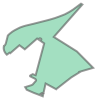

In [187]:
parks_shapes[0]

### Turning Distance Calcuation into Miles
This distance is in degrees. 1 degree latitude ~= to 69 miles. 1 degree longitude ~= 40 miles at NYC's latitude.

I'm going to treat a degree as equal to 54.5 miles, the average of the lengths of the two different kinds of degrees, for the purpose of these distance calculations. This means that my calculations of distance could be off by as much as 36.25%, if the change in position is actually only a change in longitude, latitude staying the same (in other words, 1 degree change actually equaling 40 miles). For a change only in latitude (longitude staying the same), the error rate is 21%.

Unfortunately, given the time line I'm on, I'm going to accept this level of imprecision. 

I tested the code on the following two entries from parks and from permits. My calculation of 14.13 miles is reasonably accurate.

I used [this website](https://www.mapdevelopers.com/distance_from_to.php) to the straight line distance between the two _addresses_ and got 16.67 miles, which is close. It's also important to note that the closest edge of the park is actually nearer to the site in permits than the location of the street address of the park. So it appears that this code is working in the right direction.

In [204]:
point = shapely.wkt.loads(permits['point'][0])
#shape = shapely.wkt.loads()
point.distance(parks_shapes[0])*54.5

14.129698802918849

In [206]:
parks.loc[0]

address                                       132 ALTAMONT STREET
borough                                             STATEN ISLAND
name311                                            High Rock Park
objectid                                                    69247
zipcode                                                1030410306
multipolygon    MULTIPOLYGON (((-74.12362180687407 40.58475747...
Name: 0, dtype: object

In [207]:
permits.loc[0]

borough                                       MANHATTAN
bin_no                                          1056547
house_no                                           2686
street_name                                    BROADWAY
job_no                                        121207354
zip_code                                          10025
job_start_date                               2022-05-11
owners_business_type                        PARTNERSHIP
non-profit                                            N
latitude                                      40.798817
longitude                                     -73.96874
subway_count_tenth_mi                               5.0
subway_count_half_mi                               15.0
subway_count_one_mi                                42.0
subway_count_two_five_mi                          195.0
hist_dist_name                                     none
in_hist_dist                                        0.0
point                       POINT (-73.96874 40.

In [210]:
t0 = time.time()

for i in permits.index:
    t1 = time.time()
    print(f'Permit {i} started.')
    point = shapely.wkt.loads(permits['point'][i])
    close_park = 99999
    name_close_park = ''
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < close_park:
            close_park = distance
            name_close_park = parks.loc[n, 'name311']
    permits.loc[i, 'closest_park'] = close_park
    permits.loc[i, 'name_closest_park'] = name_close_park
    print(f"Permit {i} finished at {time.time()}, after {time.time()-t1}, {time.time()-t0} since the start of the permit {i} code.")
print(f'Time to complete code: {time.time()-t0}') 

Permit 0 started.
Permit 0 finished at 1660149304.9431, after 0.040258169174194336, 0.040760040283203125 since the start of the permit 0 code.
Permit 1 started.
Permit 1 finished at 1660149304.954628, after 0.011425971984863281, 0.052284955978393555 since the start of the permit 1 code.
Permit 2 started.
Permit 2 finished at 1660149304.96576, after 0.011053085327148438, 0.0634150505065918 since the start of the permit 2 code.
Permit 3 started.
Permit 3 finished at 1660149304.976394, after 0.010577917098999023, 0.07404708862304688 since the start of the permit 3 code.
Permit 4 started.
Permit 4 finished at 1660149304.985397, after 0.008949041366577148, 0.08305096626281738 since the start of the permit 4 code.
Permit 5 started.
Permit 5 finished at 1660149304.993645, after 0.00819706916809082, 0.09129810333251953 since the start of the permit 5 code.
Permit 6 started.
Permit 6 finished at 1660149305.0017312, after 0.008051156997680664, 0.09938478469848633 since the start of the permit 6 

Looking at some of these to make sure they make sense... They line up. Interestingly, the Malls on Broadway are considered a park. So an address on Broadway is considered to be at a park.

In [211]:
permits.head()

,borough,bin_no,house_no,street_name,job_no,zip_code,job_start_date,owners_business_type,non-profit,latitude,longitude,subway_count_tenth_mi,subway_count_half_mi,subway_count_one_mi,subway_count_two_five_mi,hist_dist_name,in_hist_dist,point,closest_park,name_closest_park
0,MANHATTAN,1056547,2686,BROADWAY,121207354,10025,2022-05-11,PARTNERSHIP,N,40.798817,-73.968740,5.0,15.0,42.0,195.0,none,0.0,POINT (-73.96874 40.798817),0.000000,Broadway Malls
1,MANHATTAN,1812187,140,HILLSIDE AVENUE,121189524,10040,2022-05-11,CORPORATION,N,40.860296,-73.926125,2.0,15.0,34.0,153.0,none,0.0,POINT (-73.926125 40.860296),0.049425,Highbridge Park
2,BRONX,2823631,368,EAST 152 STREET,220586168,10455,2022-05-11,INDIVIDUAL,N,40.818565,-73.918118,0.0,9.0,60.0,215.0,none,0.0,POINT (-73.918118 40.818565),0.086285,Melrose Playground
3,BROOKLYN,3429007,3410,FARRAGUT ROAD,321588215,11210,2022-05-18,INDIVIDUAL,N,40.636513,-73.943944,0.0,11.0,13.0,95.0,none,0.0,POINT (-73.943944 40.636513),0.141644,Nostrand Playground
4,BROOKLYN,3121674,1457,FLATBUSH AVENUE,321827163,11210,2022-05-11,CORPORATION,N,40.634773,-73.949721,0.0,11.0,20.0,87.0,none,0.0,POINT (-73.949721 40.634773),0.199042,Nostrand Playground


In [287]:
#permits = pd.read_csv("../backup_data/perm_sub_hist_BACKUP.csv")

## Parks within a given radius

In [291]:
# note: the lati../backup_data/and longitude I'm using are in decimals NOT minutes, so I do the same here
# these are set at a tenth of a mile to start, with 1 degree lat = 69 miles and 1 degree longitude = 40 miles
max_delt_lat = 1/690 #CHANGE HERE
max_delt_long = 1/400 #CHANGE HERE

t0 = time.time()
print("Tenth mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < .1: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_tenth_mi'] = count #CHANGE HERE

print("Time to run tenth mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 5/690 #CHANGE HERE
max_delt_long = 5/400 #CHANGE HERE

t0 = time.time()
print("Half mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < .5: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_half_mi'] = count #CHANGE HERE

print("Time to run half mile:", time.time()-t0) #CHANGE HERE
print('')


max_delt_lat = 10/690 #CHANGE HERE
max_delt_long = 10/400 #CHANGE HERE

t0 = time.time()
print("Mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < 1: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_one_mi'] = count #CHANGE HERE

print("Time to run one mile:", time.time()-t0) #CHANGE HERE
print('')

max_delt_lat = 25/690 #CHANGE HERE
max_delt_long = 25/400 #CHANGE HERE

t0 = time.time()
print("2.5 mile started ", t0)
for i in permits.index:
    #lat = permits.loc[i, 'latitude']
    #long = permits.loc[i, 'longitude']
    #point1 = [lat, long]
    count = 0
    point = shapely.wkt.loads(permits.loc[i, 'point'])
    for n in range(0, len(parks_shapes)):
        distance = point.distance(parks_shapes[n])*54.5
        if distance < 2.5: # CHANGE HERE
            count += 1
    permits.loc[i, 'park_count_two_five_mi'] = count #CHANGE HERE

print("Time to run 2.5 mile:", time.time()-t0) #CHANGE HERE
print('')

Tenth mile started  1660166462.799236
Time to run tenth mile: 56.2216420173645

Half mile started  1660166519.021438
Time to run half mile: 56.1364049911499

Mile started  1660166575.158311
Time to run one mile: 56.5649299621582

2.5 mile started  1660166631.723728
Time to run 2.5 mile: 56.65438199043274



# Dummify Variables

In [292]:
permits.to_csv('data/final_permits.csv')